In [15]:
%matplotlib inline

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [17]:
#To determine if your system supports CUDA
print("==> Check devices..")
if torch.cuda.is_available():
    device = 'cuda'
else:    
    device = 'cpu'
print("Current device: ",device)
if device == 'cuda':
    print("Our selected device: ", torch.cuda.current_device())
    print(torch.cuda.device_count(), " GPUs is available")

==> Check devices..
Current device:  cuda
Our selected device:  0
1  GPUs is available


In [18]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:, i, :, :].mean()
            std[i] += inputs[:, i, :, :].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

In [19]:
calculate_mean_std = False

if calculate_mean_std == True:
    #we will calculate mean and std
    #The transform function for train data
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])

    transform_val = transforms.Compose([
        transforms.ToTensor(),
    ])

    #The transform function for test data
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.ImageFolder(root='../data/cinic10/aug-18000', transform=transform_train)
    valset = torchvision.datasets.ImageFolder(root='../data/cinic10/valid-224', transform=transform_val)
    testset = torchvision.datasets.ImageFolder(root='../data/cinic10/test-224', transform=transform_test)

    train_mean, train_std = get_mean_and_std(trainset)
    print(train_mean, train_std)
    val_mean, val_std = get_mean_and_std(valset)
    print(val_mean, val_std)
    test_mean, test_std = get_mean_and_std(testset)
    print(test_mean, test_std)
else:
    train_mean, train_std = ([0.4739, 0.4673, 0.4268]), ([0.1979, 0.1957, 0.1974])
    val_mean, val_std = ([0.4786, 0.4718, 0.4299]), ([0.1906, 0.1873, 0.1907])
    test_mean, test_std = ([0.4787, 0.4722, 0.4304]), ([0.1907, 0.1874, 0.1909])

In [20]:
#The transform function for train data
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

#The transform function for validation data
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(val_mean, val_std)
])

#The transform function for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std)
])

In [21]:
trainset = torchvision.datasets.ImageFolder(root='../data/cinic10/aug-18000', transform=transform_train)
valset = torchvision.datasets.ImageFolder(root='../data/cinic10/valid-224', transform=transform_val)
testset = torchvision.datasets.ImageFolder(root='../data/cinic10/test-224', transform=transform_test)

In [72]:
bs = 8
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
    shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=bs,
    shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
    shuffle=False, num_workers=2)

In [73]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [74]:
import torch.nn as nn

In [75]:
model = torchvision.models.resnet18(pretrained=False)
if device == 'cuda':
    model = model.cuda(0)
else:
    model = model.cpu()

In [76]:
import torch.optim as optim

#loss function
criterion = nn.CrossEntropyLoss()
#optimization algorithm
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

In [77]:
for phase in ['train', 'val']:
    if phase == 'train':
        print(phase)    
    else:
        print(phase)

train
val


In [78]:
import copy

best_model = model
best_acc = 0.0
val_acc = 0.0
print(device)

model.train()
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, verbose=True)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.5)

for epoch in range(200):  # loop over the dataset multiple times
        
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
            dset_loaders = trainloader
        else:
            model.train(False)  # Set model to evaluate mode
            dset_loaders = valloader
            
        running_loss = 0.0
        correct = 0
        
        for i, data in enumerate(dset_loaders, 0):
        
            (inputs, labels) = data
            
            #change the type into cuda tensor 
            if device == 'cuda':
                inputs = inputs.cuda(0)
                labels = labels.cuda(0)
            else:
                inputs = inputs.cpu()
                labels = labels.cpu()

            #print(labels)
            #print(inputs)
        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # select the class with highest probability
            _, pred = outputs.max(1)
            # if the model predicts the same results as the true
            # label, then the correct counter will plus 1
            correct += pred.eq(labels).sum().item()
        
            loss = criterion(outputs, labels)
        
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i % 200) == 199:    # print every 200 mini-batches
                print('[%d, %5d]' % (epoch + 1, i + 1))
            
        if phase == 'train':
            epoch_loss = running_loss / len(trainset)
            epoch_acc = correct / len(trainset)
        else:
            epoch_loss = running_loss / len(valset)
            epoch_acc = correct / len(valset)
            val_acc = epoch_acc

        print('{:d} Epoch {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(model)
            torch.save(best_model, './model.pt')
    lr_scheduler.step(val_acc)
print('Finished Training')

model = best_model

cuda
[1,   200]
[1,   400]
[1,   600]
[1,   800]
[1,  1000]
[1,  1200]
[1,  1400]
[1,  1600]
[1,  1800]
[1,  2000]
[1,  2200]
[1,  2400]
[1,  2600]
[1,  2800]
[1,  3000]
[1,  3200]
[1,  3400]
[1,  3600]
[1,  3800]
[1,  4000]
[1,  4200]
[1,  4400]
[1,  4600]
[1,  4800]
[1,  5000]
[1,  5200]
[1,  5400]
[1,  5600]
[1,  5800]
[1,  6000]
[1,  6200]
[1,  6400]
[1,  6600]
[1,  6800]
[1,  7000]
[1,  7200]
[1,  7400]
[1,  7600]
[1,  7800]
[1,  8000]
[1,  8200]
[1,  8400]
[1,  8600]
[1,  8800]
[1,  9000]
[1,  9200]
[1,  9400]
[1,  9600]
[1,  9800]
[1, 10000]
[1, 10200]
[1, 10400]
[1, 10600]
[1, 10800]
[1, 11000]
[1, 11200]
[1, 11400]
[1, 11600]
[1, 11800]
[1, 12000]
[1, 12200]
[1, 12400]
[1, 12600]
[1, 12800]
[1, 13000]
[1, 13200]
[1, 13400]
[1, 13600]
[1, 13800]
[1, 14000]
[1, 14200]
[1, 14400]
[1, 14600]
[1, 14800]
[1, 15000]
[1, 15200]
[1, 15400]
[1, 15600]
[1, 15800]
[1, 16000]
[1, 16200]
[1, 16400]
[1, 16600]
[1, 16800]
[1, 17000]
[1, 17200]
[1, 17400]
[1, 17600]
[1, 17800]
[1, 18000]
[1, 1

[5,  9200]
[5,  9400]
[5,  9600]
[5,  9800]
[5, 10000]
[5, 10200]
[5, 10400]
[5, 10600]
[5, 10800]
[5, 11000]
[5, 11200]
[5, 11400]
[5, 11600]
[5, 11800]
[5, 12000]
[5, 12200]
[5, 12400]
[5, 12600]
[5, 12800]
[5, 13000]
[5, 13200]
[5, 13400]
[5, 13600]
[5, 13800]
[5, 14000]
[5, 14200]
[5, 14400]
[5, 14600]
[5, 14800]
[5, 15000]
[5, 15200]
[5, 15400]
[5, 15600]
[5, 15800]
[5, 16000]
[5, 16200]
[5, 16400]
[5, 16600]
[5, 16800]
[5, 17000]
[5, 17200]
[5, 17400]
[5, 17600]
[5, 17800]
[5, 18000]
[5, 18200]
[5, 18400]
[5, 18600]
[5, 18800]
[5, 19000]
[5, 19200]
[5, 19400]
[5, 19600]
[5, 19800]
[5, 20000]
[5, 20200]
[5, 20400]
[5, 20600]
[5, 20800]
[5, 21000]
[5, 21200]
[5, 21400]
[5, 21600]
[5, 21800]
[5, 22000]
[5, 22200]
[5, 22400]
4 Epoch train Loss: 0.1372 Acc: 0.6163
[5,   200]
[5,   400]
[5,   600]
[5,   800]
[5,  1000]
[5,  1200]
[5,  1400]
[5,  1600]
[5,  1800]
[5,  2000]
[5,  2200]
[5,  2400]
[5,  2600]
[5,  2800]
[5,  3000]
[5,  3200]
[5,  3400]
[5,  3600]
[5,  3800]
[5,  4000]
[5, 

[9, 18400]
[9, 18600]
[9, 18800]
[9, 19000]
[9, 19200]
[9, 19400]
[9, 19600]
[9, 19800]
[9, 20000]
[9, 20200]
[9, 20400]
[9, 20600]
[9, 20800]
[9, 21000]
[9, 21200]
[9, 21400]
[9, 21600]
[9, 21800]
[9, 22000]
[9, 22200]
[9, 22400]
8 Epoch train Loss: 0.1343 Acc: 0.6243
[9,   200]
[9,   400]
[9,   600]
[9,   800]
[9,  1000]
[9,  1200]
[9,  1400]
[9,  1600]
[9,  1800]
[9,  2000]
[9,  2200]
[9,  2400]
[9,  2600]
[9,  2800]
[9,  3000]
[9,  3200]
[9,  3400]
[9,  3600]
[9,  3800]
[9,  4000]
[9,  4200]
[9,  4400]
[9,  4600]
[9,  4800]
[9,  5000]
[9,  5200]
[9,  5400]
[9,  5600]
[9,  5800]
[9,  6000]
[9,  6200]
[9,  6400]
[9,  6600]
[9,  6800]
[9,  7000]
[9,  7200]
[9,  7400]
[9,  7600]
[9,  7800]
[9,  8000]
[9,  8200]
[9,  8400]
[9,  8600]
[9,  8800]
[9,  9000]
[9,  9200]
[9,  9400]
[9,  9600]
[9,  9800]
[9, 10000]
[9, 10200]
[9, 10400]
[9, 10600]
[9, 10800]
[9, 11000]
[9, 11200]
8 Epoch val Loss: 0.1187 Acc: 0.6686
[10,   200]
[10,   400]
[10,   600]
[10,   800]
[10,  1000]
[10,  1200]
[10, 

[13, 16800]
[13, 17000]
[13, 17200]
[13, 17400]
[13, 17600]
[13, 17800]
[13, 18000]
[13, 18200]
[13, 18400]
[13, 18600]
[13, 18800]
[13, 19000]
[13, 19200]
[13, 19400]
[13, 19600]
[13, 19800]
[13, 20000]
[13, 20200]
[13, 20400]
[13, 20600]
[13, 20800]
[13, 21000]
[13, 21200]
[13, 21400]
[13, 21600]
[13, 21800]
[13, 22000]
[13, 22200]
[13, 22400]
12 Epoch train Loss: 0.1335 Acc: 0.6268
[13,   200]
[13,   400]
[13,   600]
[13,   800]
[13,  1000]
[13,  1200]
[13,  1400]
[13,  1600]
[13,  1800]
[13,  2000]
[13,  2200]
[13,  2400]
[13,  2600]
[13,  2800]
[13,  3000]
[13,  3200]
[13,  3400]
[13,  3600]
[13,  3800]
[13,  4000]
[13,  4200]
[13,  4400]
[13,  4600]
[13,  4800]
[13,  5000]
[13,  5200]
[13,  5400]
[13,  5600]
[13,  5800]
[13,  6000]
[13,  6200]
[13,  6400]
[13,  6600]
[13,  6800]
[13,  7000]
[13,  7200]
[13,  7400]
[13,  7600]
[13,  7800]
[13,  8000]
[13,  8200]
[13,  8400]
[13,  8600]
[13,  8800]
[13,  9000]
[13,  9200]
[13,  9400]
[13,  9600]
[13,  9800]
[13, 10000]
[13, 10200]


[17, 12800]
[17, 13000]
[17, 13200]
[17, 13400]
[17, 13600]
[17, 13800]
[17, 14000]
[17, 14200]
[17, 14400]
[17, 14600]
[17, 14800]
[17, 15000]
[17, 15200]
[17, 15400]
[17, 15600]
[17, 15800]
[17, 16000]
[17, 16200]
[17, 16400]
[17, 16600]
[17, 16800]
[17, 17000]
[17, 17200]
[17, 17400]
[17, 17600]
[17, 17800]
[17, 18000]
[17, 18200]
[17, 18400]
[17, 18600]
[17, 18800]
[17, 19000]
[17, 19200]
[17, 19400]
[17, 19600]
[17, 19800]
[17, 20000]
[17, 20200]
[17, 20400]
[17, 20600]
[17, 20800]
[17, 21000]
[17, 21200]
[17, 21400]
[17, 21600]
[17, 21800]
[17, 22000]
[17, 22200]
[17, 22400]
16 Epoch train Loss: 0.0938 Acc: 0.7412
[17,   200]
[17,   400]
[17,   600]
[17,   800]
[17,  1000]
[17,  1200]
[17,  1400]
[17,  1600]
[17,  1800]
[17,  2000]
[17,  2200]
[17,  2400]
[17,  2600]
[17,  2800]
[17,  3000]
[17,  3200]
[17,  3400]
[17,  3600]
[17,  3800]
[17,  4000]
[17,  4200]
[17,  4400]
[17,  4600]
[17,  4800]
[17,  5000]
[17,  5200]
[17,  5400]
[17,  5600]
[17,  5800]
[17,  6000]
[17,  6200]


[21,  9800]
[21, 10000]
[21, 10200]
[21, 10400]
[21, 10600]
[21, 10800]
[21, 11000]
[21, 11200]
[21, 11400]
[21, 11600]
[21, 11800]
[21, 12000]
[21, 12200]
[21, 12400]
[21, 12600]
[21, 12800]
[21, 13000]
[21, 13200]
[21, 13400]
[21, 13600]
[21, 13800]
[21, 14000]
[21, 14200]
[21, 14400]
[21, 14600]
[21, 14800]
[21, 15000]
[21, 15200]
[21, 15400]
[21, 15600]
[21, 15800]
[21, 16000]
[21, 16200]
[21, 16400]
[21, 16600]
[21, 16800]
[21, 17000]
[21, 17200]
[21, 17400]
[21, 17600]
[21, 17800]
[21, 18000]
[21, 18200]
[21, 18400]
[21, 18600]
[21, 18800]
[21, 19000]
[21, 19200]
[21, 19400]
[21, 19600]
[21, 19800]
[21, 20000]
[21, 20200]
[21, 20400]
[21, 20600]
[21, 20800]
[21, 21000]
[21, 21200]
[21, 21400]
[21, 21600]
[21, 21800]
[21, 22000]
[21, 22200]
[21, 22400]
20 Epoch train Loss: 0.0888 Acc: 0.7558
[21,   200]
[21,   400]
[21,   600]
[21,   800]
[21,  1000]
[21,  1200]
[21,  1400]
[21,  1600]
[21,  1800]
[21,  2000]
[21,  2200]
[21,  2400]
[21,  2600]
[21,  2800]
[21,  3000]
[21,  3200]


[25,  5800]
[25,  6000]
[25,  6200]
[25,  6400]
[25,  6600]
[25,  6800]
[25,  7000]
[25,  7200]
[25,  7400]
[25,  7600]
[25,  7800]
[25,  8000]
[25,  8200]
[25,  8400]
[25,  8600]
[25,  8800]
[25,  9000]
[25,  9200]
[25,  9400]
[25,  9600]
[25,  9800]
[25, 10000]
[25, 10200]
[25, 10400]
[25, 10600]
[25, 10800]
[25, 11000]
[25, 11200]
[25, 11400]
[25, 11600]
[25, 11800]
[25, 12000]
[25, 12200]
[25, 12400]
[25, 12600]
[25, 12800]
[25, 13000]
[25, 13200]
[25, 13400]
[25, 13600]
[25, 13800]
[25, 14000]
[25, 14200]
[25, 14400]
[25, 14600]
[25, 14800]
[25, 15000]
[25, 15200]
[25, 15400]
[25, 15600]
[25, 15800]
[25, 16000]
[25, 16200]
[25, 16400]
[25, 16600]
[25, 16800]
[25, 17000]
[25, 17200]
[25, 17400]
[25, 17600]
[25, 17800]
[25, 18000]
[25, 18200]
[25, 18400]
[25, 18600]
[25, 18800]
[25, 19000]
[25, 19200]
[25, 19400]
[25, 19600]
[25, 19800]
[25, 20000]
[25, 20200]
[25, 20400]
[25, 20600]
[25, 20800]
[25, 21000]
[25, 21200]
[25, 21400]
[25, 21600]
[25, 21800]
[25, 22000]
[25, 22200]
[25,

[29,  2800]
[29,  3000]
[29,  3200]
[29,  3400]
[29,  3600]
[29,  3800]
[29,  4000]
[29,  4200]
[29,  4400]
[29,  4600]
[29,  4800]
[29,  5000]
[29,  5200]
[29,  5400]
[29,  5600]
[29,  5800]
[29,  6000]
[29,  6200]
[29,  6400]
[29,  6600]
[29,  6800]
[29,  7000]
[29,  7200]
[29,  7400]
[29,  7600]
[29,  7800]
[29,  8000]
[29,  8200]
[29,  8400]
[29,  8600]
[29,  8800]
[29,  9000]
[29,  9200]
[29,  9400]
[29,  9600]
[29,  9800]
[29, 10000]
[29, 10200]
[29, 10400]
[29, 10600]
[29, 10800]
[29, 11000]
[29, 11200]
[29, 11400]
[29, 11600]
[29, 11800]
[29, 12000]
[29, 12200]
[29, 12400]
[29, 12600]
[29, 12800]
[29, 13000]
[29, 13200]
[29, 13400]
[29, 13600]
[29, 13800]
[29, 14000]
[29, 14200]
[29, 14400]
[29, 14600]
[29, 14800]
[29, 15000]
[29, 15200]
[29, 15400]
[29, 15600]
[29, 15800]
[29, 16000]
[29, 16200]
[29, 16400]
[29, 16600]
[29, 16800]
[29, 17000]
[29, 17200]
[29, 17400]
[29, 17600]
[29, 17800]
[29, 18000]
[29, 18200]
[29, 18400]
[29, 18600]
[29, 18800]
[29, 19000]
[29, 19200]
[29,

[33,   200]
[33,   400]
[33,   600]
[33,   800]
[33,  1000]
[33,  1200]
[33,  1400]
[33,  1600]
[33,  1800]
[33,  2000]
[33,  2200]
[33,  2400]
[33,  2600]
[33,  2800]
[33,  3000]
[33,  3200]
[33,  3400]
[33,  3600]
[33,  3800]
[33,  4000]
[33,  4200]
[33,  4400]
[33,  4600]
[33,  4800]
[33,  5000]
[33,  5200]
[33,  5400]
[33,  5600]
[33,  5800]
[33,  6000]
[33,  6200]
[33,  6400]
[33,  6600]
[33,  6800]
[33,  7000]
[33,  7200]
[33,  7400]
[33,  7600]
[33,  7800]
[33,  8000]
[33,  8200]
[33,  8400]
[33,  8600]
[33,  8800]
[33,  9000]
[33,  9200]
[33,  9400]
[33,  9600]
[33,  9800]
[33, 10000]
[33, 10200]
[33, 10400]
[33, 10600]
[33, 10800]
[33, 11000]
[33, 11200]
[33, 11400]
[33, 11600]
[33, 11800]
[33, 12000]
[33, 12200]
[33, 12400]
[33, 12600]
[33, 12800]
[33, 13000]
[33, 13200]
[33, 13400]
[33, 13600]
[33, 13800]
[33, 14000]
[33, 14200]
[33, 14400]
[33, 14600]
[33, 14800]
[33, 15000]
[33, 15200]
[33, 15400]
[33, 15600]
[33, 15800]
[33, 16000]
[33, 16200]
[33, 16400]
[33, 16600]
[33,

[36,  8000]
[36,  8200]
[36,  8400]
[36,  8600]
[36,  8800]
[36,  9000]
[36,  9200]
[36,  9400]
[36,  9600]
[36,  9800]
[36, 10000]
[36, 10200]
[36, 10400]
[36, 10600]
[36, 10800]
[36, 11000]
[36, 11200]
35 Epoch val Loss: 0.0764 Acc: 0.8205
[37,   200]
[37,   400]
[37,   600]
[37,   800]
[37,  1000]
[37,  1200]
[37,  1400]
[37,  1600]
[37,  1800]
[37,  2000]
[37,  2200]
[37,  2400]
[37,  2600]
[37,  2800]
[37,  3000]
[37,  3200]
[37,  3400]
[37,  3600]
[37,  3800]
[37,  4000]
[37,  4200]
[37,  4400]
[37,  4600]
[37,  4800]
[37,  5000]
[37,  5200]
[37,  5400]
[37,  5600]
[37,  5800]
[37,  6000]
[37,  6200]
[37,  6400]
[37,  6600]
[37,  6800]
[37,  7000]
[37,  7200]
[37,  7400]
[37,  7600]
[37,  7800]
[37,  8000]
[37,  8200]
[37,  8400]
[37,  8600]
[37,  8800]
[37,  9000]
[37,  9200]
[37,  9400]
[37,  9600]
[37,  9800]
[37, 10000]
[37, 10200]
[37, 10400]
[37, 10600]
[37, 10800]
[37, 11000]
[37, 11200]
[37, 11400]
[37, 11600]
[37, 11800]
[37, 12000]
[37, 12200]
[37, 12400]
[37, 12600]
[3

[40,  5000]
[40,  5200]
[40,  5400]
[40,  5600]
[40,  5800]
[40,  6000]
[40,  6200]
[40,  6400]
[40,  6600]
[40,  6800]
[40,  7000]
[40,  7200]
[40,  7400]
[40,  7600]
[40,  7800]
[40,  8000]
[40,  8200]
[40,  8400]
[40,  8600]
[40,  8800]
[40,  9000]
[40,  9200]
[40,  9400]
[40,  9600]
[40,  9800]
[40, 10000]
[40, 10200]
[40, 10400]
[40, 10600]
[40, 10800]
[40, 11000]
[40, 11200]
39 Epoch val Loss: 0.0796 Acc: 0.8218
[41,   200]
[41,   400]
[41,   600]
[41,   800]
[41,  1000]
[41,  1200]
[41,  1400]
[41,  1600]
[41,  1800]
[41,  2000]
[41,  2200]
[41,  2400]
[41,  2600]
[41,  2800]
[41,  3000]
[41,  3200]
[41,  3400]
[41,  3600]
[41,  3800]
[41,  4000]
[41,  4200]
[41,  4400]
[41,  4600]
[41,  4800]
[41,  5000]
[41,  5200]
[41,  5400]
[41,  5600]
[41,  5800]
[41,  6000]
[41,  6200]
[41,  6400]
[41,  6600]
[41,  6800]
[41,  7000]
[41,  7200]
[41,  7400]
[41,  7600]
[41,  7800]
[41,  8000]
[41,  8200]
[41,  8400]
[41,  8600]
[41,  8800]
[41,  9000]
[41,  9200]
[41,  9400]
[41,  9600]
[4

[44,  2000]
[44,  2200]
[44,  2400]
[44,  2600]
[44,  2800]
[44,  3000]
[44,  3200]
[44,  3400]
[44,  3600]
[44,  3800]
[44,  4000]
[44,  4200]
[44,  4400]
[44,  4600]
[44,  4800]
[44,  5000]
[44,  5200]
[44,  5400]
[44,  5600]
[44,  5800]
[44,  6000]
[44,  6200]
[44,  6400]
[44,  6600]
[44,  6800]
[44,  7000]
[44,  7200]
[44,  7400]
[44,  7600]
[44,  7800]
[44,  8000]
[44,  8200]
[44,  8400]
[44,  8600]
[44,  8800]
[44,  9000]
[44,  9200]
[44,  9400]
[44,  9600]
[44,  9800]
[44, 10000]
[44, 10200]
[44, 10400]
[44, 10600]
[44, 10800]
[44, 11000]
[44, 11200]
43 Epoch val Loss: 0.0816 Acc: 0.8206
[45,   200]
[45,   400]
[45,   600]
[45,   800]
[45,  1000]
[45,  1200]
[45,  1400]
[45,  1600]
[45,  1800]
[45,  2000]
[45,  2200]
[45,  2400]
[45,  2600]
[45,  2800]
[45,  3000]
[45,  3200]
[45,  3400]
[45,  3600]
[45,  3800]
[45,  4000]
[45,  4200]
[45,  4400]
[45,  4600]
[45,  4800]
[45,  5000]
[45,  5200]
[45,  5400]
[45,  5600]
[45,  5800]
[45,  6000]
[45,  6200]
[45,  6400]
[45,  6600]
[4

[48, 21000]
[48, 21200]
[48, 21400]
[48, 21600]
[48, 21800]
[48, 22000]
[48, 22200]
[48, 22400]
47 Epoch train Loss: 0.0011 Acc: 0.9997
[48,   200]
[48,   400]
[48,   600]
[48,   800]
[48,  1000]
[48,  1200]
[48,  1400]
[48,  1600]
[48,  1800]
[48,  2000]
[48,  2200]
[48,  2400]
[48,  2600]
[48,  2800]
[48,  3000]
[48,  3200]
[48,  3400]
[48,  3600]
[48,  3800]
[48,  4000]
[48,  4200]
[48,  4400]
[48,  4600]
[48,  4800]
[48,  5000]
[48,  5200]
[48,  5400]
[48,  5600]
[48,  5800]
[48,  6000]
[48,  6200]
[48,  6400]
[48,  6600]
[48,  6800]
[48,  7000]
[48,  7200]
[48,  7400]
[48,  7600]
[48,  7800]
[48,  8000]
[48,  8200]
[48,  8400]
[48,  8600]
[48,  8800]
[48,  9000]
[48,  9200]
[48,  9400]
[48,  9600]
[48,  9800]
[48, 10000]
[48, 10200]
[48, 10400]
[48, 10600]
[48, 10800]
[48, 11000]
[48, 11200]
47 Epoch val Loss: 0.0803 Acc: 0.8242
[49,   200]
[49,   400]
[49,   600]
[49,   800]
[49,  1000]
[49,  1200]
[49,  1400]
[49,  1600]
[49,  1800]
[49,  2000]
[49,  2200]
[49,  2400]
[49,  2600

[52, 18000]
[52, 18200]
[52, 18400]
[52, 18600]
[52, 18800]
[52, 19000]
[52, 19200]
[52, 19400]
[52, 19600]
[52, 19800]
[52, 20000]
[52, 20200]
[52, 20400]
[52, 20600]
[52, 20800]
[52, 21000]
[52, 21200]
[52, 21400]
[52, 21600]
[52, 21800]
[52, 22000]
[52, 22200]
[52, 22400]
51 Epoch train Loss: 0.0010 Acc: 0.9998
[52,   200]
[52,   400]
[52,   600]
[52,   800]
[52,  1000]
[52,  1200]
[52,  1400]
[52,  1600]
[52,  1800]
[52,  2000]
[52,  2200]
[52,  2400]
[52,  2600]
[52,  2800]
[52,  3000]
[52,  3200]
[52,  3400]
[52,  3600]
[52,  3800]
[52,  4000]
[52,  4200]
[52,  4400]
[52,  4600]
[52,  4800]
[52,  5000]
[52,  5200]
[52,  5400]
[52,  5600]
[52,  5800]
[52,  6000]
[52,  6200]
[52,  6400]
[52,  6600]
[52,  6800]
[52,  7000]
[52,  7200]
[52,  7400]
[52,  7600]
[52,  7800]
[52,  8000]
[52,  8200]
[52,  8400]
[52,  8600]
[52,  8800]
[52,  9000]
[52,  9200]
[52,  9400]
[52,  9600]
[52,  9800]
[52, 10000]
[52, 10200]
[52, 10400]
[52, 10600]
[52, 10800]
[52, 11000]
[52, 11200]
51 Epoch val

[56, 15000]
[56, 15200]
[56, 15400]
[56, 15600]
[56, 15800]
[56, 16000]
[56, 16200]
[56, 16400]
[56, 16600]
[56, 16800]
[56, 17000]
[56, 17200]
[56, 17400]
[56, 17600]
[56, 17800]
[56, 18000]
[56, 18200]
[56, 18400]
[56, 18600]
[56, 18800]
[56, 19000]
[56, 19200]
[56, 19400]
[56, 19600]
[56, 19800]
[56, 20000]
[56, 20200]
[56, 20400]
[56, 20600]
[56, 20800]
[56, 21000]
[56, 21200]
[56, 21400]
[56, 21600]
[56, 21800]
[56, 22000]
[56, 22200]
[56, 22400]
55 Epoch train Loss: 0.0010 Acc: 0.9998
[56,   200]
[56,   400]
[56,   600]
[56,   800]
[56,  1000]
[56,  1200]
[56,  1400]
[56,  1600]
[56,  1800]
[56,  2000]
[56,  2200]
[56,  2400]
[56,  2600]
[56,  2800]
[56,  3000]
[56,  3200]
[56,  3400]
[56,  3600]
[56,  3800]
[56,  4000]
[56,  4200]
[56,  4400]
[56,  4600]
[56,  4800]
[56,  5000]
[56,  5200]
[56,  5400]
[56,  5600]
[56,  5800]
[56,  6000]
[56,  6200]
[56,  6400]
[56,  6600]
[56,  6800]
[56,  7000]
[56,  7200]
[56,  7400]
[56,  7600]
[56,  7800]
[56,  8000]
[56,  8200]
[56,  8400]


[60, 11000]
[60, 11200]
[60, 11400]
[60, 11600]
[60, 11800]
[60, 12000]
[60, 12200]
[60, 12400]
[60, 12600]
[60, 12800]
[60, 13000]
[60, 13200]
[60, 13400]
[60, 13600]
[60, 13800]
[60, 14000]
[60, 14200]
[60, 14400]
[60, 14600]
[60, 14800]
[60, 15000]
[60, 15200]
[60, 15400]
[60, 15600]
[60, 15800]
[60, 16000]
[60, 16200]
[60, 16400]
[60, 16600]
[60, 16800]
[60, 17000]
[60, 17200]
[60, 17400]
[60, 17600]
[60, 17800]
[60, 18000]
[60, 18200]
[60, 18400]
[60, 18600]
[60, 18800]
[60, 19000]
[60, 19200]
[60, 19400]
[60, 19600]
[60, 19800]
[60, 20000]
[60, 20200]
[60, 20400]
[60, 20600]
[60, 20800]
[60, 21000]
[60, 21200]
[60, 21400]
[60, 21600]
[60, 21800]
[60, 22000]
[60, 22200]
[60, 22400]
59 Epoch train Loss: 0.0009 Acc: 0.9998
[60,   200]
[60,   400]
[60,   600]
[60,   800]
[60,  1000]
[60,  1200]
[60,  1400]
[60,  1600]
[60,  1800]
[60,  2000]
[60,  2200]
[60,  2400]
[60,  2600]
[60,  2800]
[60,  3000]
[60,  3200]
[60,  3400]
[60,  3600]
[60,  3800]
[60,  4000]
[60,  4200]
[60,  4400]


[64,  8000]
[64,  8200]
[64,  8400]
[64,  8600]
[64,  8800]
[64,  9000]
[64,  9200]
[64,  9400]
[64,  9600]
[64,  9800]
[64, 10000]
[64, 10200]
[64, 10400]
[64, 10600]
[64, 10800]
[64, 11000]
[64, 11200]
[64, 11400]
[64, 11600]
[64, 11800]
[64, 12000]
[64, 12200]
[64, 12400]
[64, 12600]
[64, 12800]
[64, 13000]
[64, 13200]
[64, 13400]
[64, 13600]
[64, 13800]
[64, 14000]
[64, 14200]
[64, 14400]
[64, 14600]
[64, 14800]
[64, 15000]
[64, 15200]
[64, 15400]
[64, 15600]
[64, 15800]
[64, 16000]
[64, 16200]
[64, 16400]
[64, 16600]
[64, 16800]
[64, 17000]
[64, 17200]
[64, 17400]
[64, 17600]
[64, 17800]
[64, 18000]
[64, 18200]
[64, 18400]
[64, 18600]
[64, 18800]
[64, 19000]
[64, 19200]
[64, 19400]
[64, 19600]
[64, 19800]
[64, 20000]
[64, 20200]
[64, 20400]
[64, 20600]
[64, 20800]
[64, 21000]
[64, 21200]
[64, 21400]
[64, 21600]
[64, 21800]
[64, 22000]
[64, 22200]
[64, 22400]
63 Epoch train Loss: 0.0009 Acc: 0.9998
[64,   200]
[64,   400]
[64,   600]
[64,   800]
[64,  1000]
[64,  1200]
[64,  1400]


[68,  5000]
[68,  5200]
[68,  5400]
[68,  5600]
[68,  5800]
[68,  6000]
[68,  6200]
[68,  6400]
[68,  6600]
[68,  6800]
[68,  7000]
[68,  7200]
[68,  7400]
[68,  7600]
[68,  7800]
[68,  8000]
[68,  8200]
[68,  8400]
[68,  8600]
[68,  8800]
[68,  9000]
[68,  9200]
[68,  9400]
[68,  9600]
[68,  9800]
[68, 10000]
[68, 10200]
[68, 10400]
[68, 10600]
[68, 10800]
[68, 11000]
[68, 11200]
[68, 11400]
[68, 11600]
[68, 11800]
[68, 12000]
[68, 12200]
[68, 12400]
[68, 12600]
[68, 12800]
[68, 13000]
[68, 13200]
[68, 13400]
[68, 13600]
[68, 13800]
[68, 14000]
[68, 14200]
[68, 14400]
[68, 14600]
[68, 14800]
[68, 15000]
[68, 15200]
[68, 15400]
[68, 15600]
[68, 15800]
[68, 16000]
[68, 16200]
[68, 16400]
[68, 16600]
[68, 16800]
[68, 17000]
[68, 17200]
[68, 17400]
[68, 17600]
[68, 17800]
[68, 18000]
[68, 18200]
[68, 18400]
[68, 18600]
[68, 18800]
[68, 19000]
[68, 19200]
[68, 19400]
[68, 19600]
[68, 19800]
[68, 20000]
[68, 20200]
[68, 20400]
[68, 20600]
[68, 20800]
[68, 21000]
[68, 21200]
[68, 21400]
[68,

[72,  1000]
[72,  1200]
[72,  1400]
[72,  1600]
[72,  1800]
[72,  2000]
[72,  2200]
[72,  2400]
[72,  2600]
[72,  2800]
[72,  3000]
[72,  3200]
[72,  3400]
[72,  3600]
[72,  3800]
[72,  4000]
[72,  4200]
[72,  4400]
[72,  4600]
[72,  4800]
[72,  5000]
[72,  5200]
[72,  5400]
[72,  5600]
[72,  5800]
[72,  6000]
[72,  6200]
[72,  6400]
[72,  6600]
[72,  6800]
[72,  7000]
[72,  7200]
[72,  7400]
[72,  7600]
[72,  7800]
[72,  8000]
[72,  8200]
[72,  8400]
[72,  8600]
[72,  8800]
[72,  9000]
[72,  9200]
[72,  9400]
[72,  9600]
[72,  9800]
[72, 10000]
[72, 10200]
[72, 10400]
[72, 10600]
[72, 10800]
[72, 11000]
[72, 11200]
[72, 11400]
[72, 11600]
[72, 11800]
[72, 12000]
[72, 12200]
[72, 12400]
[72, 12600]
[72, 12800]
[72, 13000]
[72, 13200]
[72, 13400]
[72, 13600]
[72, 13800]
[72, 14000]
[72, 14200]
[72, 14400]
[72, 14600]
[72, 14800]
[72, 15000]
[72, 15200]
[72, 15400]
[72, 15600]
[72, 15800]
[72, 16000]
[72, 16200]
[72, 16400]
[72, 16600]
[72, 16800]
[72, 17000]
[72, 17200]
[72, 17400]
[72,

[75,  9800]
[75, 10000]
[75, 10200]
[75, 10400]
[75, 10600]
[75, 10800]
[75, 11000]
[75, 11200]
74 Epoch val Loss: 0.0804 Acc: 0.8239
[76,   200]
[76,   400]
[76,   600]
[76,   800]
[76,  1000]
[76,  1200]
[76,  1400]
[76,  1600]
[76,  1800]
[76,  2000]
[76,  2200]
[76,  2400]
[76,  2600]
[76,  2800]
[76,  3000]
[76,  3200]
[76,  3400]
[76,  3600]
[76,  3800]
[76,  4000]
[76,  4200]
[76,  4400]
[76,  4600]
[76,  4800]
[76,  5000]
[76,  5200]
[76,  5400]
[76,  5600]
[76,  5800]
[76,  6000]
[76,  6200]
[76,  6400]
[76,  6600]
[76,  6800]
[76,  7000]
[76,  7200]
[76,  7400]
[76,  7600]
[76,  7800]
[76,  8000]
[76,  8200]
[76,  8400]
[76,  8600]
[76,  8800]
[76,  9000]
[76,  9200]
[76,  9400]
[76,  9600]
[76,  9800]
[76, 10000]
[76, 10200]
[76, 10400]
[76, 10600]
[76, 10800]
[76, 11000]
[76, 11200]
[76, 11400]
[76, 11600]
[76, 11800]
[76, 12000]
[76, 12200]
[76, 12400]
[76, 12600]
[76, 12800]
[76, 13000]
[76, 13200]
[76, 13400]
[76, 13600]
[76, 13800]
[76, 14000]
[76, 14200]
[76, 14400]
[7

[79,  6800]
[79,  7000]
[79,  7200]
[79,  7400]
[79,  7600]
[79,  7800]
[79,  8000]
[79,  8200]
[79,  8400]
[79,  8600]
[79,  8800]
[79,  9000]
[79,  9200]
[79,  9400]
[79,  9600]
[79,  9800]
[79, 10000]
[79, 10200]
[79, 10400]
[79, 10600]
[79, 10800]
[79, 11000]
[79, 11200]
78 Epoch val Loss: 0.0803 Acc: 0.8242
Epoch    78: reducing learning rate of group 0 to 2.1870e-06.
[80,   200]
[80,   400]
[80,   600]
[80,   800]
[80,  1000]
[80,  1200]
[80,  1400]
[80,  1600]
[80,  1800]
[80,  2000]
[80,  2200]
[80,  2400]
[80,  2600]
[80,  2800]
[80,  3000]
[80,  3200]
[80,  3400]
[80,  3600]
[80,  3800]
[80,  4000]
[80,  4200]
[80,  4400]
[80,  4600]
[80,  4800]
[80,  5000]
[80,  5200]
[80,  5400]
[80,  5600]
[80,  5800]
[80,  6000]
[80,  6200]
[80,  6400]
[80,  6600]
[80,  6800]
[80,  7000]
[80,  7200]
[80,  7400]
[80,  7600]
[80,  7800]
[80,  8000]
[80,  8200]
[80,  8400]
[80,  8600]
[80,  8800]
[80,  9000]
[80,  9200]
[80,  9400]
[80,  9600]
[80,  9800]
[80, 10000]
[80, 10200]
[80, 10400]


[83,  2800]
[83,  3000]
[83,  3200]
[83,  3400]
[83,  3600]
[83,  3800]
[83,  4000]
[83,  4200]
[83,  4400]
[83,  4600]
[83,  4800]
[83,  5000]
[83,  5200]
[83,  5400]
[83,  5600]
[83,  5800]
[83,  6000]
[83,  6200]
[83,  6400]
[83,  6600]
[83,  6800]
[83,  7000]
[83,  7200]
[83,  7400]
[83,  7600]
[83,  7800]
[83,  8000]
[83,  8200]
[83,  8400]
[83,  8600]
[83,  8800]
[83,  9000]
[83,  9200]
[83,  9400]
[83,  9600]
[83,  9800]
[83, 10000]
[83, 10200]
[83, 10400]
[83, 10600]
[83, 10800]
[83, 11000]
[83, 11200]
82 Epoch val Loss: 0.0802 Acc: 0.8256
[84,   200]
[84,   400]
[84,   600]
[84,   800]
[84,  1000]
[84,  1200]
[84,  1400]
[84,  1600]
[84,  1800]
[84,  2000]
[84,  2200]
[84,  2400]
[84,  2600]
[84,  2800]
[84,  3000]
[84,  3200]
[84,  3400]
[84,  3600]
[84,  3800]
[84,  4000]
[84,  4200]
[84,  4400]
[84,  4600]
[84,  4800]
[84,  5000]
[84,  5200]
[84,  5400]
[84,  5600]
[84,  5800]
[84,  6000]
[84,  6200]
[84,  6400]
[84,  6600]
[84,  6800]
[84,  7000]
[84,  7200]
[84,  7400]
[8

[87,   200]
[87,   400]
[87,   600]
[87,   800]
[87,  1000]
[87,  1200]
[87,  1400]
[87,  1600]
[87,  1800]
[87,  2000]
[87,  2200]
[87,  2400]
[87,  2600]
[87,  2800]
[87,  3000]
[87,  3200]
[87,  3400]
[87,  3600]
[87,  3800]
[87,  4000]
[87,  4200]
[87,  4400]
[87,  4600]
[87,  4800]
[87,  5000]
[87,  5200]
[87,  5400]
[87,  5600]
[87,  5800]
[87,  6000]
[87,  6200]
[87,  6400]
[87,  6600]
[87,  6800]
[87,  7000]
[87,  7200]
[87,  7400]
[87,  7600]
[87,  7800]
[87,  8000]
[87,  8200]
[87,  8400]
[87,  8600]
[87,  8800]
[87,  9000]
[87,  9200]
[87,  9400]
[87,  9600]
[87,  9800]
[87, 10000]
[87, 10200]
[87, 10400]
[87, 10600]
[87, 10800]
[87, 11000]
[87, 11200]
86 Epoch val Loss: 0.0801 Acc: 0.8250
[88,   200]
[88,   400]
[88,   600]
[88,   800]
[88,  1000]
[88,  1200]
[88,  1400]
[88,  1600]
[88,  1800]
[88,  2000]
[88,  2200]
[88,  2400]
[88,  2600]
[88,  2800]
[88,  3000]
[88,  3200]
[88,  3400]
[88,  3600]
[88,  3800]
[88,  4000]
[88,  4200]
[88,  4400]
[88,  4600]
[88,  4800]
[8

[91, 19200]
[91, 19400]
[91, 19600]
[91, 19800]
[91, 20000]
[91, 20200]
[91, 20400]
[91, 20600]
[91, 20800]
[91, 21000]
[91, 21200]
[91, 21400]
[91, 21600]
[91, 21800]
[91, 22000]
[91, 22200]
[91, 22400]
90 Epoch train Loss: 0.0008 Acc: 0.9998
[91,   200]
[91,   400]
[91,   600]
[91,   800]
[91,  1000]
[91,  1200]
[91,  1400]
[91,  1600]
[91,  1800]
[91,  2000]
[91,  2200]
[91,  2400]
[91,  2600]
[91,  2800]
[91,  3000]
[91,  3200]
[91,  3400]
[91,  3600]
[91,  3800]
[91,  4000]
[91,  4200]
[91,  4400]
[91,  4600]
[91,  4800]
[91,  5000]
[91,  5200]
[91,  5400]
[91,  5600]
[91,  5800]
[91,  6000]
[91,  6200]
[91,  6400]
[91,  6600]
[91,  6800]
[91,  7000]
[91,  7200]
[91,  7400]
[91,  7600]
[91,  7800]
[91,  8000]
[91,  8200]
[91,  8400]
[91,  8600]
[91,  8800]
[91,  9000]
[91,  9200]
[91,  9400]
[91,  9600]
[91,  9800]
[91, 10000]
[91, 10200]
[91, 10400]
[91, 10600]
[91, 10800]
[91, 11000]
[91, 11200]
90 Epoch val Loss: 0.0804 Acc: 0.8253
[92,   200]
[92,   400]
[92,   600]
[92,   800

[95, 16200]
[95, 16400]
[95, 16600]
[95, 16800]
[95, 17000]
[95, 17200]
[95, 17400]
[95, 17600]
[95, 17800]
[95, 18000]
[95, 18200]
[95, 18400]
[95, 18600]
[95, 18800]
[95, 19000]
[95, 19200]
[95, 19400]
[95, 19600]
[95, 19800]
[95, 20000]
[95, 20200]
[95, 20400]
[95, 20600]
[95, 20800]
[95, 21000]
[95, 21200]
[95, 21400]
[95, 21600]
[95, 21800]
[95, 22000]
[95, 22200]
[95, 22400]
94 Epoch train Loss: 0.0008 Acc: 0.9998
[95,   200]
[95,   400]
[95,   600]
[95,   800]
[95,  1000]
[95,  1200]
[95,  1400]
[95,  1600]
[95,  1800]
[95,  2000]
[95,  2200]
[95,  2400]
[95,  2600]
[95,  2800]
[95,  3000]
[95,  3200]
[95,  3400]
[95,  3600]
[95,  3800]
[95,  4000]
[95,  4200]
[95,  4400]
[95,  4600]
[95,  4800]
[95,  5000]
[95,  5200]
[95,  5400]
[95,  5600]
[95,  5800]
[95,  6000]
[95,  6200]
[95,  6400]
[95,  6600]
[95,  6800]
[95,  7000]
[95,  7200]
[95,  7400]
[95,  7600]
[95,  7800]
[95,  8000]
[95,  8200]
[95,  8400]
[95,  8600]
[95,  8800]
[95,  9000]
[95,  9200]
[95,  9400]
[95,  9600]


[99, 13200]
[99, 13400]
[99, 13600]
[99, 13800]
[99, 14000]
[99, 14200]
[99, 14400]
[99, 14600]
[99, 14800]
[99, 15000]
[99, 15200]
[99, 15400]
[99, 15600]
[99, 15800]
[99, 16000]
[99, 16200]
[99, 16400]
[99, 16600]
[99, 16800]
[99, 17000]
[99, 17200]
[99, 17400]
[99, 17600]
[99, 17800]
[99, 18000]
[99, 18200]
[99, 18400]
[99, 18600]
[99, 18800]
[99, 19000]
[99, 19200]
[99, 19400]
[99, 19600]
[99, 19800]
[99, 20000]
[99, 20200]
[99, 20400]
[99, 20600]
[99, 20800]
[99, 21000]
[99, 21200]
[99, 21400]
[99, 21600]
[99, 21800]
[99, 22000]
[99, 22200]
[99, 22400]
98 Epoch train Loss: 0.0008 Acc: 0.9998
[99,   200]
[99,   400]
[99,   600]
[99,   800]
[99,  1000]
[99,  1200]
[99,  1400]
[99,  1600]
[99,  1800]
[99,  2000]
[99,  2200]
[99,  2400]
[99,  2600]
[99,  2800]
[99,  3000]
[99,  3200]
[99,  3400]
[99,  3600]
[99,  3800]
[99,  4000]
[99,  4200]
[99,  4400]
[99,  4600]
[99,  4800]
[99,  5000]
[99,  5200]
[99,  5400]
[99,  5600]
[99,  5800]
[99,  6000]
[99,  6200]
[99,  6400]
[99,  6600]


[103,   800]
[103,  1000]
[103,  1200]
[103,  1400]
[103,  1600]
[103,  1800]
[103,  2000]
[103,  2200]
[103,  2400]
[103,  2600]
[103,  2800]
[103,  3000]
[103,  3200]
[103,  3400]
[103,  3600]
[103,  3800]
[103,  4000]
[103,  4200]
[103,  4400]
[103,  4600]
[103,  4800]
[103,  5000]
[103,  5200]
[103,  5400]
[103,  5600]
[103,  5800]
[103,  6000]
[103,  6200]
[103,  6400]
[103,  6600]
[103,  6800]
[103,  7000]
[103,  7200]
[103,  7400]
[103,  7600]
[103,  7800]
[103,  8000]
[103,  8200]
[103,  8400]
[103,  8600]
[103,  8800]
[103,  9000]
[103,  9200]
[103,  9400]
[103,  9600]
[103,  9800]
[103, 10000]
[103, 10200]
[103, 10400]
[103, 10600]
[103, 10800]
[103, 11000]
[103, 11200]
[103, 11400]
[103, 11600]
[103, 11800]
[103, 12000]
[103, 12200]
[103, 12400]
[103, 12600]
[103, 12800]
[103, 13000]
[103, 13200]
[103, 13400]
[103, 13600]
[103, 13800]
[103, 14000]
[103, 14200]
[103, 14400]
[103, 14600]
[103, 14800]
[103, 15000]
[103, 15200]
[103, 15400]
[103, 15600]
[103, 15800]
[103, 16000]

[106, 22400]
105 Epoch train Loss: 0.0008 Acc: 0.9998
[106,   200]
[106,   400]
[106,   600]
[106,   800]
[106,  1000]
[106,  1200]
[106,  1400]
[106,  1600]
[106,  1800]
[106,  2000]
[106,  2200]
[106,  2400]
[106,  2600]
[106,  2800]
[106,  3000]
[106,  3200]
[106,  3400]
[106,  3600]
[106,  3800]
[106,  4000]
[106,  4200]
[106,  4400]
[106,  4600]
[106,  4800]
[106,  5000]
[106,  5200]
[106,  5400]
[106,  5600]
[106,  5800]
[106,  6000]
[106,  6200]
[106,  6400]
[106,  6600]
[106,  6800]
[106,  7000]
[106,  7200]
[106,  7400]
[106,  7600]
[106,  7800]
[106,  8000]
[106,  8200]
[106,  8400]
[106,  8600]
[106,  8800]
[106,  9000]
[106,  9200]
[106,  9400]
[106,  9600]
[106,  9800]
[106, 10000]
[106, 10200]
[106, 10400]
[106, 10600]
[106, 10800]
[106, 11000]
[106, 11200]
105 Epoch val Loss: 0.0806 Acc: 0.8244
[107,   200]
[107,   400]
[107,   600]
[107,   800]
[107,  1000]
[107,  1200]
[107,  1400]
[107,  1600]
[107,  1800]
[107,  2000]
[107,  2200]
[107,  2400]
[107,  2600]
[107,  280

[110,  9200]
[110,  9400]
[110,  9600]
[110,  9800]
[110, 10000]
[110, 10200]
[110, 10400]
[110, 10600]
[110, 10800]
[110, 11000]
[110, 11200]
[110, 11400]
[110, 11600]
[110, 11800]
[110, 12000]
[110, 12200]
[110, 12400]
[110, 12600]
[110, 12800]
[110, 13000]
[110, 13200]
[110, 13400]
[110, 13600]
[110, 13800]
[110, 14000]
[110, 14200]
[110, 14400]
[110, 14600]
[110, 14800]
[110, 15000]
[110, 15200]
[110, 15400]
[110, 15600]
[110, 15800]
[110, 16000]
[110, 16200]
[110, 16400]
[110, 16600]
[110, 16800]
[110, 17000]
[110, 17200]
[110, 17400]
[110, 17600]
[110, 17800]
[110, 18000]
[110, 18200]
[110, 18400]
[110, 18600]
[110, 18800]
[110, 19000]
[110, 19200]
[110, 19400]
[110, 19600]
[110, 19800]
[110, 20000]
[110, 20200]
[110, 20400]
[110, 20600]
[110, 20800]
[110, 21000]
[110, 21200]
[110, 21400]
[110, 21600]
[110, 21800]
[110, 22000]
[110, 22200]
[110, 22400]
109 Epoch train Loss: 0.0008 Acc: 0.9999
[110,   200]
[110,   400]
[110,   600]
[110,   800]
[110,  1000]
[110,  1200]
[110,  140

[113,  6800]
[113,  7000]
[113,  7200]
[113,  7400]
[113,  7600]
[113,  7800]
[113,  8000]
[113,  8200]
[113,  8400]
[113,  8600]
[113,  8800]
[113,  9000]
[113,  9200]
[113,  9400]
[113,  9600]
[113,  9800]
[113, 10000]
[113, 10200]
[113, 10400]
[113, 10600]
[113, 10800]
[113, 11000]
[113, 11200]
112 Epoch val Loss: 0.0799 Acc: 0.8262
[114,   200]
[114,   400]
[114,   600]
[114,   800]
[114,  1000]
[114,  1200]
[114,  1400]
[114,  1600]
[114,  1800]
[114,  2000]
[114,  2200]
[114,  2400]
[114,  2600]
[114,  2800]
[114,  3000]
[114,  3200]
[114,  3400]
[114,  3600]
[114,  3800]
[114,  4000]
[114,  4200]
[114,  4400]
[114,  4600]
[114,  4800]
[114,  5000]
[114,  5200]
[114,  5400]
[114,  5600]
[114,  5800]
[114,  6000]
[114,  6200]
[114,  6400]
[114,  6600]
[114,  6800]
[114,  7000]
[114,  7200]
[114,  7400]
[114,  7600]
[114,  7800]
[114,  8000]
[114,  8200]
[114,  8400]
[114,  8600]
[114,  8800]
[114,  9000]
[114,  9200]
[114,  9400]
[114,  9600]
[114,  9800]
[114, 10000]
[114, 10200]

[117, 16600]
[117, 16800]
[117, 17000]
[117, 17200]
[117, 17400]
[117, 17600]
[117, 17800]
[117, 18000]
[117, 18200]
[117, 18400]
[117, 18600]
[117, 18800]
[117, 19000]
[117, 19200]
[117, 19400]
[117, 19600]
[117, 19800]
[117, 20000]
[117, 20200]
[117, 20400]
[117, 20600]
[117, 20800]
[117, 21000]
[117, 21200]
[117, 21400]
[117, 21600]
[117, 21800]
[117, 22000]
[117, 22200]
[117, 22400]
116 Epoch train Loss: 0.0008 Acc: 0.9998
[117,   200]
[117,   400]
[117,   600]
[117,   800]
[117,  1000]
[117,  1200]
[117,  1400]
[117,  1600]
[117,  1800]
[117,  2000]
[117,  2200]
[117,  2400]
[117,  2600]
[117,  2800]
[117,  3000]
[117,  3200]
[117,  3400]
[117,  3600]
[117,  3800]
[117,  4000]
[117,  4200]
[117,  4400]
[117,  4600]
[117,  4800]
[117,  5000]
[117,  5200]
[117,  5400]
[117,  5600]
[117,  5800]
[117,  6000]
[117,  6200]
[117,  6400]
[117,  6600]
[117,  6800]
[117,  7000]
[117,  7200]
[117,  7400]
[117,  7600]
[117,  7800]
[117,  8000]
[117,  8200]
[117,  8400]
[117,  8600]
[117,  880

[121,  3400]
[121,  3600]
[121,  3800]
[121,  4000]
[121,  4200]
[121,  4400]
[121,  4600]
[121,  4800]
[121,  5000]
[121,  5200]
[121,  5400]
[121,  5600]
[121,  5800]
[121,  6000]
[121,  6200]
[121,  6400]
[121,  6600]
[121,  6800]
[121,  7000]
[121,  7200]
[121,  7400]
[121,  7600]
[121,  7800]
[121,  8000]
[121,  8200]
[121,  8400]
[121,  8600]
[121,  8800]
[121,  9000]
[121,  9200]
[121,  9400]
[121,  9600]
[121,  9800]
[121, 10000]
[121, 10200]
[121, 10400]
[121, 10600]
[121, 10800]
[121, 11000]
[121, 11200]
[121, 11400]
[121, 11600]
[121, 11800]
[121, 12000]
[121, 12200]
[121, 12400]
[121, 12600]
[121, 12800]
[121, 13000]
[121, 13200]
[121, 13400]
[121, 13600]
[121, 13800]
[121, 14000]
[121, 14200]
[121, 14400]
[121, 14600]
[121, 14800]
[121, 15000]
[121, 15200]
[121, 15400]
[121, 15600]
[121, 15800]
[121, 16000]
[121, 16200]
[121, 16400]
[121, 16600]
[121, 16800]
[121, 17000]
[121, 17200]
[121, 17400]
[121, 17600]
[121, 17800]
[121, 18000]
[121, 18200]
[121, 18400]
[121, 18600]

[124,  1000]
[124,  1200]
[124,  1400]
[124,  1600]
[124,  1800]
[124,  2000]
[124,  2200]
[124,  2400]
[124,  2600]
[124,  2800]
[124,  3000]
[124,  3200]
[124,  3400]
[124,  3600]
[124,  3800]
[124,  4000]
[124,  4200]
[124,  4400]
[124,  4600]
[124,  4800]
[124,  5000]
[124,  5200]
[124,  5400]
[124,  5600]
[124,  5800]
[124,  6000]
[124,  6200]
[124,  6400]
[124,  6600]
[124,  6800]
[124,  7000]
[124,  7200]
[124,  7400]
[124,  7600]
[124,  7800]
[124,  8000]
[124,  8200]
[124,  8400]
[124,  8600]
[124,  8800]
[124,  9000]
[124,  9200]
[124,  9400]
[124,  9600]
[124,  9800]
[124, 10000]
[124, 10200]
[124, 10400]
[124, 10600]
[124, 10800]
[124, 11000]
[124, 11200]
123 Epoch val Loss: 0.0808 Acc: 0.8250
[125,   200]
[125,   400]
[125,   600]
[125,   800]
[125,  1000]
[125,  1200]
[125,  1400]
[125,  1600]
[125,  1800]
[125,  2000]
[125,  2200]
[125,  2400]
[125,  2600]
[125,  2800]
[125,  3000]
[125,  3200]
[125,  3400]
[125,  3600]
[125,  3800]
[125,  4000]
[125,  4200]
[125,  4400]

[128, 10800]
[128, 11000]
[128, 11200]
[128, 11400]
[128, 11600]
[128, 11800]
[128, 12000]
[128, 12200]
[128, 12400]
[128, 12600]
[128, 12800]
[128, 13000]
[128, 13200]
[128, 13400]
[128, 13600]
[128, 13800]
[128, 14000]
[128, 14200]
[128, 14400]
[128, 14600]
[128, 14800]
[128, 15000]
[128, 15200]
[128, 15400]
[128, 15600]
[128, 15800]
[128, 16000]
[128, 16200]
[128, 16400]
[128, 16600]
[128, 16800]
[128, 17000]
[128, 17200]
[128, 17400]
[128, 17600]
[128, 17800]
[128, 18000]
[128, 18200]
[128, 18400]
[128, 18600]
[128, 18800]
[128, 19000]
[128, 19200]
[128, 19400]
[128, 19600]
[128, 19800]
[128, 20000]
[128, 20200]
[128, 20400]
[128, 20600]
[128, 20800]
[128, 21000]
[128, 21200]
[128, 21400]
[128, 21600]
[128, 21800]
[128, 22000]
[128, 22200]
[128, 22400]
127 Epoch train Loss: 0.0008 Acc: 0.9999
[128,   200]
[128,   400]
[128,   600]
[128,   800]
[128,  1000]
[128,  1200]
[128,  1400]
[128,  1600]
[128,  1800]
[128,  2000]
[128,  2200]
[128,  2400]
[128,  2600]
[128,  2800]
[128,  300

[131,  9400]
[131,  9600]
[131,  9800]
[131, 10000]
[131, 10200]
[131, 10400]
[131, 10600]
[131, 10800]
[131, 11000]
[131, 11200]
130 Epoch val Loss: 0.0798 Acc: 0.8250
[132,   200]
[132,   400]
[132,   600]
[132,   800]
[132,  1000]
[132,  1200]
[132,  1400]
[132,  1600]
[132,  1800]
[132,  2000]
[132,  2200]
[132,  2400]
[132,  2600]
[132,  2800]
[132,  3000]
[132,  3200]
[132,  3400]
[132,  3600]
[132,  3800]
[132,  4000]
[132,  4200]
[132,  4400]
[132,  4600]
[132,  4800]
[132,  5000]
[132,  5200]
[132,  5400]
[132,  5600]
[132,  5800]
[132,  6000]
[132,  6200]
[132,  6400]
[132,  6600]
[132,  6800]
[132,  7000]
[132,  7200]
[132,  7400]
[132,  7600]
[132,  7800]
[132,  8000]
[132,  8200]
[132,  8400]
[132,  8600]
[132,  8800]
[132,  9000]
[132,  9200]
[132,  9400]
[132,  9600]
[132,  9800]
[132, 10000]
[132, 10200]
[132, 10400]
[132, 10600]
[132, 10800]
[132, 11000]
[132, 11200]
[132, 11400]
[132, 11600]
[132, 11800]
[132, 12000]
[132, 12200]
[132, 12400]
[132, 12600]
[132, 12800]

[135, 18200]
[135, 18400]
[135, 18600]
[135, 18800]
[135, 19000]
[135, 19200]
[135, 19400]
[135, 19600]
[135, 19800]
[135, 20000]
[135, 20200]
[135, 20400]
[135, 20600]
[135, 20800]
[135, 21000]
[135, 21200]
[135, 21400]
[135, 21600]
[135, 21800]
[135, 22000]
[135, 22200]
[135, 22400]
134 Epoch train Loss: 0.0008 Acc: 0.9998
[135,   200]
[135,   400]
[135,   600]
[135,   800]
[135,  1000]
[135,  1200]
[135,  1400]
[135,  1600]
[135,  1800]
[135,  2000]
[135,  2200]
[135,  2400]
[135,  2600]
[135,  2800]
[135,  3000]
[135,  3200]
[135,  3400]
[135,  3600]
[135,  3800]
[135,  4000]
[135,  4200]
[135,  4400]
[135,  4600]
[135,  4800]
[135,  5000]
[135,  5200]
[135,  5400]
[135,  5600]
[135,  5800]
[135,  6000]
[135,  6200]
[135,  6400]
[135,  6600]
[135,  6800]
[135,  7000]
[135,  7200]
[135,  7400]
[135,  7600]
[135,  7800]
[135,  8000]
[135,  8200]
[135,  8400]
[135,  8600]
[135,  8800]
[135,  9000]
[135,  9200]
[135,  9400]
[135,  9600]
[135,  9800]
[135, 10000]
[135, 10200]
[135, 1040

[139,  5000]
[139,  5200]
[139,  5400]
[139,  5600]
[139,  5800]
[139,  6000]
[139,  6200]
[139,  6400]
[139,  6600]
[139,  6800]
[139,  7000]
[139,  7200]
[139,  7400]
[139,  7600]
[139,  7800]
[139,  8000]
[139,  8200]
[139,  8400]
[139,  8600]
[139,  8800]
[139,  9000]
[139,  9200]
[139,  9400]
[139,  9600]
[139,  9800]
[139, 10000]
[139, 10200]
[139, 10400]
[139, 10600]
[139, 10800]
[139, 11000]
[139, 11200]
[139, 11400]
[139, 11600]
[139, 11800]
[139, 12000]
[139, 12200]
[139, 12400]
[139, 12600]
[139, 12800]
[139, 13000]
[139, 13200]
[139, 13400]
[139, 13600]
[139, 13800]
[139, 14000]
[139, 14200]
[139, 14400]
[139, 14600]
[139, 14800]
[139, 15000]
[139, 15200]
[139, 15400]
[139, 15600]
[139, 15800]
[139, 16000]
[139, 16200]
[139, 16400]
[139, 16600]
[139, 16800]
[139, 17000]
[139, 17200]
[139, 17400]
[139, 17600]
[139, 17800]
[139, 18000]
[139, 18200]
[139, 18400]
[139, 18600]
[139, 18800]
[139, 19000]
[139, 19200]
[139, 19400]
[139, 19600]
[139, 19800]
[139, 20000]
[139, 20200]

[142,  3600]
[142,  3800]
[142,  4000]
[142,  4200]
[142,  4400]
[142,  4600]
[142,  4800]
[142,  5000]
[142,  5200]
[142,  5400]
[142,  5600]
[142,  5800]
[142,  6000]
[142,  6200]
[142,  6400]
[142,  6600]
[142,  6800]
[142,  7000]
[142,  7200]
[142,  7400]
[142,  7600]
[142,  7800]
[142,  8000]
[142,  8200]
[142,  8400]
[142,  8600]
[142,  8800]
[142,  9000]
[142,  9200]
[142,  9400]
[142,  9600]
[142,  9800]
[142, 10000]
[142, 10200]
[142, 10400]
[142, 10600]
[142, 10800]
[142, 11000]
[142, 11200]
141 Epoch val Loss: 0.0798 Acc: 0.8255
[143,   200]
[143,   400]
[143,   600]
[143,   800]
[143,  1000]
[143,  1200]
[143,  1400]
[143,  1600]
[143,  1800]
[143,  2000]
[143,  2200]
[143,  2400]
[143,  2600]
[143,  2800]
[143,  3000]
[143,  3200]
[143,  3400]
[143,  3600]
[143,  3800]
[143,  4000]
[143,  4200]
[143,  4400]
[143,  4600]
[143,  4800]
[143,  5000]
[143,  5200]
[143,  5400]
[143,  5600]
[143,  5800]
[143,  6000]
[143,  6200]
[143,  6400]
[143,  6600]
[143,  6800]
[143,  7000]

[146, 13400]
[146, 13600]
[146, 13800]
[146, 14000]
[146, 14200]
[146, 14400]
[146, 14600]
[146, 14800]
[146, 15000]
[146, 15200]
[146, 15400]
[146, 15600]
[146, 15800]
[146, 16000]
[146, 16200]
[146, 16400]
[146, 16600]
[146, 16800]
[146, 17000]
[146, 17200]
[146, 17400]
[146, 17600]
[146, 17800]
[146, 18000]
[146, 18200]
[146, 18400]
[146, 18600]
[146, 18800]
[146, 19000]
[146, 19200]
[146, 19400]
[146, 19600]
[146, 19800]
[146, 20000]
[146, 20200]
[146, 20400]
[146, 20600]
[146, 20800]
[146, 21000]
[146, 21200]
[146, 21400]
[146, 21600]
[146, 21800]
[146, 22000]
[146, 22200]
[146, 22400]
145 Epoch train Loss: 0.0008 Acc: 0.9998
[146,   200]
[146,   400]
[146,   600]
[146,   800]
[146,  1000]
[146,  1200]
[146,  1400]
[146,  1600]
[146,  1800]
[146,  2000]
[146,  2200]
[146,  2400]
[146,  2600]
[146,  2800]
[146,  3000]
[146,  3200]
[146,  3400]
[146,  3600]
[146,  3800]
[146,  4000]
[146,  4200]
[146,  4400]
[146,  4600]
[146,  4800]
[146,  5000]
[146,  5200]
[146,  5400]
[146,  560

[150,   200]
[150,   400]
[150,   600]
[150,   800]
[150,  1000]
[150,  1200]
[150,  1400]
[150,  1600]
[150,  1800]
[150,  2000]
[150,  2200]
[150,  2400]
[150,  2600]
[150,  2800]
[150,  3000]
[150,  3200]
[150,  3400]
[150,  3600]
[150,  3800]
[150,  4000]
[150,  4200]
[150,  4400]
[150,  4600]
[150,  4800]
[150,  5000]
[150,  5200]
[150,  5400]
[150,  5600]
[150,  5800]
[150,  6000]
[150,  6200]
[150,  6400]
[150,  6600]
[150,  6800]
[150,  7000]
[150,  7200]
[150,  7400]
[150,  7600]
[150,  7800]
[150,  8000]
[150,  8200]
[150,  8400]
[150,  8600]
[150,  8800]
[150,  9000]
[150,  9200]
[150,  9400]
[150,  9600]
[150,  9800]
[150, 10000]
[150, 10200]
[150, 10400]
[150, 10600]
[150, 10800]
[150, 11000]
[150, 11200]
[150, 11400]
[150, 11600]
[150, 11800]
[150, 12000]
[150, 12200]
[150, 12400]
[150, 12600]
[150, 12800]
[150, 13000]
[150, 13200]
[150, 13400]
[150, 13600]
[150, 13800]
[150, 14000]
[150, 14200]
[150, 14400]
[150, 14600]
[150, 14800]
[150, 15000]
[150, 15200]
[150, 15400]

[153, 21800]
[153, 22000]
[153, 22200]
[153, 22400]
152 Epoch train Loss: 0.0008 Acc: 0.9998
[153,   200]
[153,   400]
[153,   600]
[153,   800]
[153,  1000]
[153,  1200]
[153,  1400]
[153,  1600]
[153,  1800]
[153,  2000]
[153,  2200]
[153,  2400]
[153,  2600]
[153,  2800]
[153,  3000]
[153,  3200]
[153,  3400]
[153,  3600]
[153,  3800]
[153,  4000]
[153,  4200]
[153,  4400]
[153,  4600]
[153,  4800]
[153,  5000]
[153,  5200]
[153,  5400]
[153,  5600]
[153,  5800]
[153,  6000]
[153,  6200]
[153,  6400]
[153,  6600]
[153,  6800]
[153,  7000]
[153,  7200]
[153,  7400]
[153,  7600]
[153,  7800]
[153,  8000]
[153,  8200]
[153,  8400]
[153,  8600]
[153,  8800]
[153,  9000]
[153,  9200]
[153,  9400]
[153,  9600]
[153,  9800]
[153, 10000]
[153, 10200]
[153, 10400]
[153, 10600]
[153, 10800]
[153, 11000]
[153, 11200]
152 Epoch val Loss: 0.0807 Acc: 0.8243
[154,   200]
[154,   400]
[154,   600]
[154,   800]
[154,  1000]
[154,  1200]
[154,  1400]
[154,  1600]
[154,  1800]
[154,  2000]
[154,  220

[157,  8600]
[157,  8800]
[157,  9000]
[157,  9200]
[157,  9400]
[157,  9600]
[157,  9800]
[157, 10000]
[157, 10200]
[157, 10400]
[157, 10600]
[157, 10800]
[157, 11000]
[157, 11200]
[157, 11400]
[157, 11600]
[157, 11800]
[157, 12000]
[157, 12200]
[157, 12400]
[157, 12600]
[157, 12800]
[157, 13000]
[157, 13200]
[157, 13400]
[157, 13600]
[157, 13800]
[157, 14000]
[157, 14200]
[157, 14400]
[157, 14600]
[157, 14800]
[157, 15000]
[157, 15200]
[157, 15400]
[157, 15600]
[157, 15800]
[157, 16000]
[157, 16200]
[157, 16400]
[157, 16600]
[157, 16800]
[157, 17000]
[157, 17200]
[157, 17400]
[157, 17600]
[157, 17800]
[157, 18000]
[157, 18200]
[157, 18400]
[157, 18600]
[157, 18800]
[157, 19000]
[157, 19200]
[157, 19400]
[157, 19600]
[157, 19800]
[157, 20000]
[157, 20200]
[157, 20400]
[157, 20600]
[157, 20800]
[157, 21000]
[157, 21200]
[157, 21400]
[157, 21600]
[157, 21800]
[157, 22000]
[157, 22200]
[157, 22400]
156 Epoch train Loss: 0.0008 Acc: 0.9998
[157,   200]
[157,   400]
[157,   600]
[157,   80

[160,  7200]
[160,  7400]
[160,  7600]
[160,  7800]
[160,  8000]
[160,  8200]
[160,  8400]
[160,  8600]
[160,  8800]
[160,  9000]
[160,  9200]
[160,  9400]
[160,  9600]
[160,  9800]
[160, 10000]
[160, 10200]
[160, 10400]
[160, 10600]
[160, 10800]
[160, 11000]
[160, 11200]
159 Epoch val Loss: 0.0809 Acc: 0.8251
[161,   200]
[161,   400]
[161,   600]
[161,   800]
[161,  1000]
[161,  1200]
[161,  1400]
[161,  1600]
[161,  1800]
[161,  2000]
[161,  2200]
[161,  2400]
[161,  2600]
[161,  2800]
[161,  3000]
[161,  3200]
[161,  3400]
[161,  3600]
[161,  3800]
[161,  4000]
[161,  4200]
[161,  4400]
[161,  4600]
[161,  4800]
[161,  5000]
[161,  5200]
[161,  5400]
[161,  5600]
[161,  5800]
[161,  6000]
[161,  6200]
[161,  6400]
[161,  6600]
[161,  6800]
[161,  7000]
[161,  7200]
[161,  7400]
[161,  7600]
[161,  7800]
[161,  8000]
[161,  8200]
[161,  8400]
[161,  8600]
[161,  8800]
[161,  9000]
[161,  9200]
[161,  9400]
[161,  9600]
[161,  9800]
[161, 10000]
[161, 10200]
[161, 10400]
[161, 10600]

[164, 17000]
[164, 17200]
[164, 17400]
[164, 17600]
[164, 17800]
[164, 18000]
[164, 18200]
[164, 18400]
[164, 18600]
[164, 18800]
[164, 19000]
[164, 19200]
[164, 19400]
[164, 19600]
[164, 19800]
[164, 20000]
[164, 20200]
[164, 20400]
[164, 20600]
[164, 20800]
[164, 21000]
[164, 21200]
[164, 21400]
[164, 21600]
[164, 21800]
[164, 22000]
[164, 22200]
[164, 22400]
163 Epoch train Loss: 0.0008 Acc: 0.9998
[164,   200]
[164,   400]
[164,   600]
[164,   800]
[164,  1000]
[164,  1200]
[164,  1400]
[164,  1600]
[164,  1800]
[164,  2000]
[164,  2200]
[164,  2400]
[164,  2600]
[164,  2800]
[164,  3000]
[164,  3200]
[164,  3400]
[164,  3600]
[164,  3800]
[164,  4000]
[164,  4200]
[164,  4400]
[164,  4600]
[164,  4800]
[164,  5000]
[164,  5200]
[164,  5400]
[164,  5600]
[164,  5800]
[164,  6000]
[164,  6200]
[164,  6400]
[164,  6600]
[164,  6800]
[164,  7000]
[164,  7200]
[164,  7400]
[164,  7600]
[164,  7800]
[164,  8000]
[164,  8200]
[164,  8400]
[164,  8600]
[164,  8800]
[164,  9000]
[164,  920

[168,  3800]
[168,  4000]
[168,  4200]
[168,  4400]
[168,  4600]
[168,  4800]
[168,  5000]
[168,  5200]
[168,  5400]
[168,  5600]
[168,  5800]
[168,  6000]
[168,  6200]
[168,  6400]
[168,  6600]
[168,  6800]
[168,  7000]
[168,  7200]
[168,  7400]
[168,  7600]
[168,  7800]
[168,  8000]
[168,  8200]
[168,  8400]
[168,  8600]
[168,  8800]
[168,  9000]
[168,  9200]
[168,  9400]
[168,  9600]
[168,  9800]
[168, 10000]
[168, 10200]
[168, 10400]
[168, 10600]
[168, 10800]
[168, 11000]
[168, 11200]
[168, 11400]
[168, 11600]
[168, 11800]
[168, 12000]
[168, 12200]
[168, 12400]
[168, 12600]
[168, 12800]
[168, 13000]
[168, 13200]
[168, 13400]
[168, 13600]
[168, 13800]
[168, 14000]
[168, 14200]
[168, 14400]
[168, 14600]
[168, 14800]
[168, 15000]
[168, 15200]
[168, 15400]
[168, 15600]
[168, 15800]
[168, 16000]
[168, 16200]
[168, 16400]
[168, 16600]
[168, 16800]
[168, 17000]
[168, 17200]
[168, 17400]
[168, 17600]
[168, 17800]
[168, 18000]
[168, 18200]
[168, 18400]
[168, 18600]
[168, 18800]
[168, 19000]

[171,  2400]
[171,  2600]
[171,  2800]
[171,  3000]
[171,  3200]
[171,  3400]
[171,  3600]
[171,  3800]
[171,  4000]
[171,  4200]
[171,  4400]
[171,  4600]
[171,  4800]
[171,  5000]
[171,  5200]
[171,  5400]
[171,  5600]
[171,  5800]
[171,  6000]
[171,  6200]
[171,  6400]
[171,  6600]
[171,  6800]
[171,  7000]
[171,  7200]
[171,  7400]
[171,  7600]
[171,  7800]
[171,  8000]
[171,  8200]
[171,  8400]
[171,  8600]
[171,  8800]
[171,  9000]
[171,  9200]
[171,  9400]
[171,  9600]
[171,  9800]
[171, 10000]
[171, 10200]
[171, 10400]
[171, 10600]
[171, 10800]
[171, 11000]
[171, 11200]
170 Epoch val Loss: 0.0802 Acc: 0.8252
[172,   200]
[172,   400]
[172,   600]
[172,   800]
[172,  1000]
[172,  1200]
[172,  1400]
[172,  1600]
[172,  1800]
[172,  2000]
[172,  2200]
[172,  2400]
[172,  2600]
[172,  2800]
[172,  3000]
[172,  3200]
[172,  3400]
[172,  3600]
[172,  3800]
[172,  4000]
[172,  4200]
[172,  4400]
[172,  4600]
[172,  4800]
[172,  5000]
[172,  5200]
[172,  5400]
[172,  5600]
[172,  5800]

[175, 12200]
[175, 12400]
[175, 12600]
[175, 12800]
[175, 13000]
[175, 13200]
[175, 13400]
[175, 13600]
[175, 13800]
[175, 14000]
[175, 14200]
[175, 14400]
[175, 14600]
[175, 14800]
[175, 15000]
[175, 15200]
[175, 15400]
[175, 15600]
[175, 15800]
[175, 16000]
[175, 16200]
[175, 16400]
[175, 16600]
[175, 16800]
[175, 17000]
[175, 17200]
[175, 17400]
[175, 17600]
[175, 17800]
[175, 18000]
[175, 18200]
[175, 18400]
[175, 18600]
[175, 18800]
[175, 19000]
[175, 19200]
[175, 19400]
[175, 19600]
[175, 19800]
[175, 20000]
[175, 20200]
[175, 20400]
[175, 20600]
[175, 20800]
[175, 21000]
[175, 21200]
[175, 21400]
[175, 21600]
[175, 21800]
[175, 22000]
[175, 22200]
[175, 22400]
174 Epoch train Loss: 0.0008 Acc: 0.9998
[175,   200]
[175,   400]
[175,   600]
[175,   800]
[175,  1000]
[175,  1200]
[175,  1400]
[175,  1600]
[175,  1800]
[175,  2000]
[175,  2200]
[175,  2400]
[175,  2600]
[175,  2800]
[175,  3000]
[175,  3200]
[175,  3400]
[175,  3600]
[175,  3800]
[175,  4000]
[175,  4200]
[175,  440

[178, 10800]
[178, 11000]
[178, 11200]
177 Epoch val Loss: 0.0798 Acc: 0.8256
[179,   200]
[179,   400]
[179,   600]
[179,   800]
[179,  1000]
[179,  1200]
[179,  1400]
[179,  1600]
[179,  1800]
[179,  2000]
[179,  2200]
[179,  2400]
[179,  2600]
[179,  2800]
[179,  3000]
[179,  3200]
[179,  3400]
[179,  3600]
[179,  3800]
[179,  4000]
[179,  4200]
[179,  4400]
[179,  4600]
[179,  4800]
[179,  5000]
[179,  5200]
[179,  5400]
[179,  5600]
[179,  5800]
[179,  6000]
[179,  6200]
[179,  6400]
[179,  6600]
[179,  6800]
[179,  7000]
[179,  7200]
[179,  7400]
[179,  7600]
[179,  7800]
[179,  8000]
[179,  8200]
[179,  8400]
[179,  8600]
[179,  8800]
[179,  9000]
[179,  9200]
[179,  9400]
[179,  9600]
[179,  9800]
[179, 10000]
[179, 10200]
[179, 10400]
[179, 10600]
[179, 10800]
[179, 11000]
[179, 11200]
[179, 11400]
[179, 11600]
[179, 11800]
[179, 12000]
[179, 12200]
[179, 12400]
[179, 12600]
[179, 12800]
[179, 13000]
[179, 13200]
[179, 13400]
[179, 13600]
[179, 13800]
[179, 14000]
[179, 14200]

[182, 20600]
[182, 20800]
[182, 21000]
[182, 21200]
[182, 21400]
[182, 21600]
[182, 21800]
[182, 22000]
[182, 22200]
[182, 22400]
181 Epoch train Loss: 0.0008 Acc: 0.9998
[182,   200]
[182,   400]
[182,   600]
[182,   800]
[182,  1000]
[182,  1200]
[182,  1400]
[182,  1600]
[182,  1800]
[182,  2000]
[182,  2200]
[182,  2400]
[182,  2600]
[182,  2800]
[182,  3000]
[182,  3200]
[182,  3400]
[182,  3600]
[182,  3800]
[182,  4000]
[182,  4200]
[182,  4400]
[182,  4600]
[182,  4800]
[182,  5000]
[182,  5200]
[182,  5400]
[182,  5600]
[182,  5800]
[182,  6000]
[182,  6200]
[182,  6400]
[182,  6600]
[182,  6800]
[182,  7000]
[182,  7200]
[182,  7400]
[182,  7600]
[182,  7800]
[182,  8000]
[182,  8200]
[182,  8400]
[182,  8600]
[182,  8800]
[182,  9000]
[182,  9200]
[182,  9400]
[182,  9600]
[182,  9800]
[182, 10000]
[182, 10200]
[182, 10400]
[182, 10600]
[182, 10800]
[182, 11000]
[182, 11200]
181 Epoch val Loss: 0.0811 Acc: 0.8254
[183,   200]
[183,   400]
[183,   600]
[183,   800]
[183,  100

[186,  7400]
[186,  7600]
[186,  7800]
[186,  8000]
[186,  8200]
[186,  8400]
[186,  8600]
[186,  8800]
[186,  9000]
[186,  9200]
[186,  9400]
[186,  9600]
[186,  9800]
[186, 10000]
[186, 10200]
[186, 10400]
[186, 10600]
[186, 10800]
[186, 11000]
[186, 11200]
[186, 11400]
[186, 11600]
[186, 11800]
[186, 12000]
[186, 12200]
[186, 12400]
[186, 12600]
[186, 12800]
[186, 13000]
[186, 13200]
[186, 13400]
[186, 13600]
[186, 13800]
[186, 14000]
[186, 14200]
[186, 14400]
[186, 14600]
[186, 14800]
[186, 15000]
[186, 15200]
[186, 15400]
[186, 15600]
[186, 15800]
[186, 16000]
[186, 16200]
[186, 16400]
[186, 16600]
[186, 16800]
[186, 17000]
[186, 17200]
[186, 17400]
[186, 17600]
[186, 17800]
[186, 18000]
[186, 18200]
[186, 18400]
[186, 18600]
[186, 18800]
[186, 19000]
[186, 19200]
[186, 19400]
[186, 19600]
[186, 19800]
[186, 20000]
[186, 20200]
[186, 20400]
[186, 20600]
[186, 20800]
[186, 21000]
[186, 21200]
[186, 21400]
[186, 21600]
[186, 21800]
[186, 22000]
[186, 22200]
[186, 22400]
185 Epoch tr

[189,  6000]
[189,  6200]
[189,  6400]
[189,  6600]
[189,  6800]
[189,  7000]
[189,  7200]
[189,  7400]
[189,  7600]
[189,  7800]
[189,  8000]
[189,  8200]
[189,  8400]
[189,  8600]
[189,  8800]
[189,  9000]
[189,  9200]
[189,  9400]
[189,  9600]
[189,  9800]
[189, 10000]
[189, 10200]
[189, 10400]
[189, 10600]
[189, 10800]
[189, 11000]
[189, 11200]
188 Epoch val Loss: 0.0805 Acc: 0.8242
[190,   200]
[190,   400]
[190,   600]
[190,   800]
[190,  1000]
[190,  1200]
[190,  1400]
[190,  1600]
[190,  1800]
[190,  2000]
[190,  2200]
[190,  2400]
[190,  2600]
[190,  2800]
[190,  3000]
[190,  3200]
[190,  3400]
[190,  3600]
[190,  3800]
[190,  4000]
[190,  4200]
[190,  4400]
[190,  4600]
[190,  4800]
[190,  5000]
[190,  5200]
[190,  5400]
[190,  5600]
[190,  5800]
[190,  6000]
[190,  6200]
[190,  6400]
[190,  6600]
[190,  6800]
[190,  7000]
[190,  7200]
[190,  7400]
[190,  7600]
[190,  7800]
[190,  8000]
[190,  8200]
[190,  8400]
[190,  8600]
[190,  8800]
[190,  9000]
[190,  9200]
[190,  9400]

[193, 15800]
[193, 16000]
[193, 16200]
[193, 16400]
[193, 16600]
[193, 16800]
[193, 17000]
[193, 17200]
[193, 17400]
[193, 17600]
[193, 17800]
[193, 18000]
[193, 18200]
[193, 18400]
[193, 18600]
[193, 18800]
[193, 19000]
[193, 19200]
[193, 19400]
[193, 19600]
[193, 19800]
[193, 20000]
[193, 20200]
[193, 20400]
[193, 20600]
[193, 20800]
[193, 21000]
[193, 21200]
[193, 21400]
[193, 21600]
[193, 21800]
[193, 22000]
[193, 22200]
[193, 22400]
192 Epoch train Loss: 0.0008 Acc: 0.9998
[193,   200]
[193,   400]
[193,   600]
[193,   800]
[193,  1000]
[193,  1200]
[193,  1400]
[193,  1600]
[193,  1800]
[193,  2000]
[193,  2200]
[193,  2400]
[193,  2600]
[193,  2800]
[193,  3000]
[193,  3200]
[193,  3400]
[193,  3600]
[193,  3800]
[193,  4000]
[193,  4200]
[193,  4400]
[193,  4600]
[193,  4800]
[193,  5000]
[193,  5200]
[193,  5400]
[193,  5600]
[193,  5800]
[193,  6000]
[193,  6200]
[193,  6400]
[193,  6600]
[193,  6800]
[193,  7000]
[193,  7200]
[193,  7400]
[193,  7600]
[193,  7800]
[193,  800

[197,  2600]
[197,  2800]
[197,  3000]
[197,  3200]
[197,  3400]
[197,  3600]
[197,  3800]
[197,  4000]
[197,  4200]
[197,  4400]
[197,  4600]
[197,  4800]
[197,  5000]
[197,  5200]
[197,  5400]
[197,  5600]
[197,  5800]
[197,  6000]
[197,  6200]
[197,  6400]
[197,  6600]
[197,  6800]
[197,  7000]
[197,  7200]
[197,  7400]
[197,  7600]
[197,  7800]
[197,  8000]
[197,  8200]
[197,  8400]
[197,  8600]
[197,  8800]
[197,  9000]
[197,  9200]
[197,  9400]
[197,  9600]
[197,  9800]
[197, 10000]
[197, 10200]
[197, 10400]
[197, 10600]
[197, 10800]
[197, 11000]
[197, 11200]
[197, 11400]
[197, 11600]
[197, 11800]
[197, 12000]
[197, 12200]
[197, 12400]
[197, 12600]
[197, 12800]
[197, 13000]
[197, 13200]
[197, 13400]
[197, 13600]
[197, 13800]
[197, 14000]
[197, 14200]
[197, 14400]
[197, 14600]
[197, 14800]
[197, 15000]
[197, 15200]
[197, 15400]
[197, 15600]
[197, 15800]
[197, 16000]
[197, 16200]
[197, 16400]
[197, 16600]
[197, 16800]
[197, 17000]
[197, 17200]
[197, 17400]
[197, 17600]
[197, 17800]

[200,  1200]
[200,  1400]
[200,  1600]
[200,  1800]
[200,  2000]
[200,  2200]
[200,  2400]
[200,  2600]
[200,  2800]
[200,  3000]
[200,  3200]
[200,  3400]
[200,  3600]
[200,  3800]
[200,  4000]
[200,  4200]
[200,  4400]
[200,  4600]
[200,  4800]
[200,  5000]
[200,  5200]
[200,  5400]
[200,  5600]
[200,  5800]
[200,  6000]
[200,  6200]
[200,  6400]
[200,  6600]
[200,  6800]
[200,  7000]
[200,  7200]
[200,  7400]
[200,  7600]
[200,  7800]
[200,  8000]
[200,  8200]
[200,  8400]
[200,  8600]
[200,  8800]
[200,  9000]
[200,  9200]
[200,  9400]
[200,  9600]
[200,  9800]
[200, 10000]
[200, 10200]
[200, 10400]
[200, 10600]
[200, 10800]
[200, 11000]
[200, 11200]
199 Epoch val Loss: 0.0798 Acc: 0.8258
Finished Training


In [81]:
model = best_model
print('==> Saving model..')

#only save model parameters
torch.save(model.state_dict(), './checkpoint.t7')
#you also can store some log information
state = {
    'net': model.state_dict(),
    'acc': 100.*correct/len(trainset),
    'epoch': epoch
}
torch.save(state, './checkpoint.t7')

#save entire model
torch.save(model, './model.pt')

print('Finished Saving')

==> Saving model..
Finished Saving


In [82]:
#If you save the entire model
model = torch.load('./model.pt')

print('Finished Loading')

Finished Loading


In [83]:
print('==> Testing model..')
model.eval()

==> Testing model..


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [84]:
correct = 0
total = 0
running_loss = 0.0
# device == 'cpu'
class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))

with torch.no_grad():
    for mini_batch, data in enumerate(testloader, 0):
        images, labels = data

        if device == 'cuda':
            images = images.cuda(0)
            labels = labels.cuda(0)
        else:
            images = images.cpu()
            labels = labels.cpu()
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        c = (predicted == labels).squeeze()
        #print(predicted)
        #print(labels.size(0))
        #print(c)
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        if(mini_batch % 200 == 199):
            print('[%5d]' % (mini_batch + 1))
            
print('Accuracy of the network on the %d test images: %.2f%%, and loss is: %.3f'
      % (total, 100 * correct / total, running_loss / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

[  200]
[  400]
[  600]
[  800]
[ 1000]
[ 1200]
[ 1400]
[ 1600]
[ 1800]
[ 2000]
[ 2200]
[ 2400]
[ 2600]
[ 2800]
[ 3000]
[ 3200]
[ 3400]
[ 3600]
[ 3800]
[ 4000]
[ 4200]
[ 4400]
[ 4600]
[ 4800]
[ 5000]
[ 5200]
[ 5400]
[ 5600]
[ 5800]
[ 6000]
[ 6200]
[ 6400]
[ 6600]
[ 6800]
[ 7000]
[ 7200]
[ 7400]
[ 7600]
[ 7800]
[ 8000]
[ 8200]
[ 8400]
[ 8600]
[ 8800]
[ 9000]
[ 9200]
[ 9400]
[ 9600]
[ 9800]
[10000]
[10200]
[10400]
[10600]
[10800]
[11000]
[11200]
Accuracy of the network on the 90000 test images: 82.08%, and loss is: 0.082
Accuracy of airplane : 90 %
Accuracy of automobile : 83 %
Accuracy of  bird : 80 %
Accuracy of   cat : 74 %
Accuracy of  deer : 79 %
Accuracy of   dog : 68 %
Accuracy of  frog : 89 %
Accuracy of horse : 85 %
Accuracy of  ship : 87 %
Accuracy of truck : 81 %


In [114]:
import os
import sys
import re
from collections import OrderedDict

def train_acc_loss_result(fname):

    dictionary_acc = OrderedDict()
    dictionary_best = OrderedDict()
    dictionary_loss = OrderedDict()
    dictionary_lr = OrderedDict()
    
    with open(fname) as fp:  
        best = 0
        
        for cnt, line in enumerate(fp):
            # print("Line {}: {}".format(cnt, line))
            # 199 Epoch val Loss: 0.0798 Acc: 0.8258
            pattern = re.compile(r"(\d+) Epoch val Loss: (\d+.\d+) Acc: (\d+.\d+)")
            match = pattern.match(line)
            if match:
                epoch_str, loss_str, acc_str = match.groups()
                print('Validation --- Epoch: {:s}, loss: {:s}, acc: {:s}'.
                      format(epoch_str, loss_str, acc_str))

                Epoch = int(epoch_str)
                loss = float("{:f}".format(float(loss_str)))
                acc = float("{:f}".format(float(acc_str)))
                
                if(best < acc):
                    best = acc
                    
                dictionary_best[Epoch] = best
                
            # 199 Epoch train Loss: 0.0008 Acc: 0.9998
            pattern = re.compile(r"(\d+) Epoch train Loss: (\d+.\d+) Acc: (\d+.\d+)")
            match = pattern.match(line)
            if match:
                epoch_str, loss_str, acc_str = match.groups()
                print('Training --- Epoch: {:s}, loss: {:s}, acc: {:s}'.
                      format(epoch_str, loss_str, acc_str))

                Epoch = int(epoch_str)
                loss = float("{:f}".format(float(loss_str)))
                acc = float("{:f}".format(float(acc_str)))
                
                dictionary_acc[Epoch] = acc
                dictionary_loss[Epoch] = loss

            # Epoch    56: reducing learning rate of group 0 to 2.4300e-05.
            pattern = re.compile(r"Epoch    (\d+): reducing learning rate of group 0 to (\d+.\d+e-\d+).")
            match = pattern.match(line)
            if match:
                epoch_str, lr_str = match.groups()
                print('Learning Rate --- Epoch: {:s}, lr: {:s}'.
                      format(epoch_str, lr_str))

                Epoch = int(epoch_str)
                lr = float("{0:f}".format(float(lr_str)))
                
                dictionary_lr[Epoch] = lr
                
    return dictionary_best, dictionary_acc, dictionary_loss, dictionary_lr

In [118]:
import matplotlib.pyplot as plt
import itertools

def show_train_acc(dictionary_best, dictionary_acc, dictionary_loss, dictionary_lr):
    fig, ax1 = plt.subplots()

    fig.set_figheight(20)
    fig.set_figwidth(20)

    ax1.set_title('Training/Validation Accuracy & Loss / Learning Rate', fontsize=20)

    ax2 = ax1.twinx()
    ax2.figure.figsize=(120,120)
    
    l1, = ax1.plot(list(dictionary_best.keys()), list(dictionary_best.values()), 'g-')
    l2, = ax1.plot(list(dictionary_acc.keys()), list(dictionary_acc.values()), 'b-')
    l3, = ax2.plot(list(dictionary_loss.keys()), list(dictionary_loss.values()), 'r--')
    l4, = ax2.plot(list(dictionary_lr.keys()), list(dictionary_lr.values()), 'ro')
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='y', which='major', labelsize=20)

    ax1.set_xlabel('Epoch', fontsize=20)
    ax1.set_ylabel('Accuracy', fontsize=20, color='#008888')
    ax2.set_ylabel('Loss / rate', fontsize=20, color='r')
    ax2.set_yscale("log", nonposy='clip')

    #ax1.set(ylim=[0, 100])
    #ax2.set(ylim=[0, 0.2])
    
    ax1.grid(axis='both', which='both')
    plt.legend(handles=[l1, l2, l3, l4],
               labels=['Best Accuracy', 'Train Accuracy', 'Loss', 'learning rate'], fontsize=20, loc='right')

    plt.show()

In [119]:
fname = './fp-1 v6.log'
dictionary_best, dictionary_acc, dictionary_loss, dictionary_lr = train_acc_loss_result(fname)

Training --- Epoch: 0, loss: 0.1896, acc: 0.4503
Validation --- Epoch: 0, loss: 0.1509, acc: 0.5718
Training --- Epoch: 1, loss: 0.1519, acc: 0.5709
Validation --- Epoch: 1, loss: 0.1552, acc: 0.5599
Training --- Epoch: 2, loss: 0.1428, acc: 0.5986
Validation --- Epoch: 2, loss: 0.1535, acc: 0.5717
Training --- Epoch: 3, loss: 0.1389, acc: 0.6105
Validation --- Epoch: 3, loss: 0.1324, acc: 0.6314
Training --- Epoch: 4, loss: 0.1372, acc: 0.6163
Validation --- Epoch: 4, loss: 0.1476, acc: 0.5939
Training --- Epoch: 5, loss: 0.1359, acc: 0.6207
Validation --- Epoch: 5, loss: 0.1231, acc: 0.6596
Training --- Epoch: 6, loss: 0.1355, acc: 0.6213
Validation --- Epoch: 6, loss: 0.1327, acc: 0.6257
Training --- Epoch: 7, loss: 0.1348, acc: 0.6234
Validation --- Epoch: 7, loss: 0.1242, acc: 0.6570
Training --- Epoch: 8, loss: 0.1343, acc: 0.6243
Validation --- Epoch: 8, loss: 0.1187, acc: 0.6686
Training --- Epoch: 9, loss: 0.1341, acc: 0.6255
Validation --- Epoch: 9, loss: 0.1324, acc: 0.6232


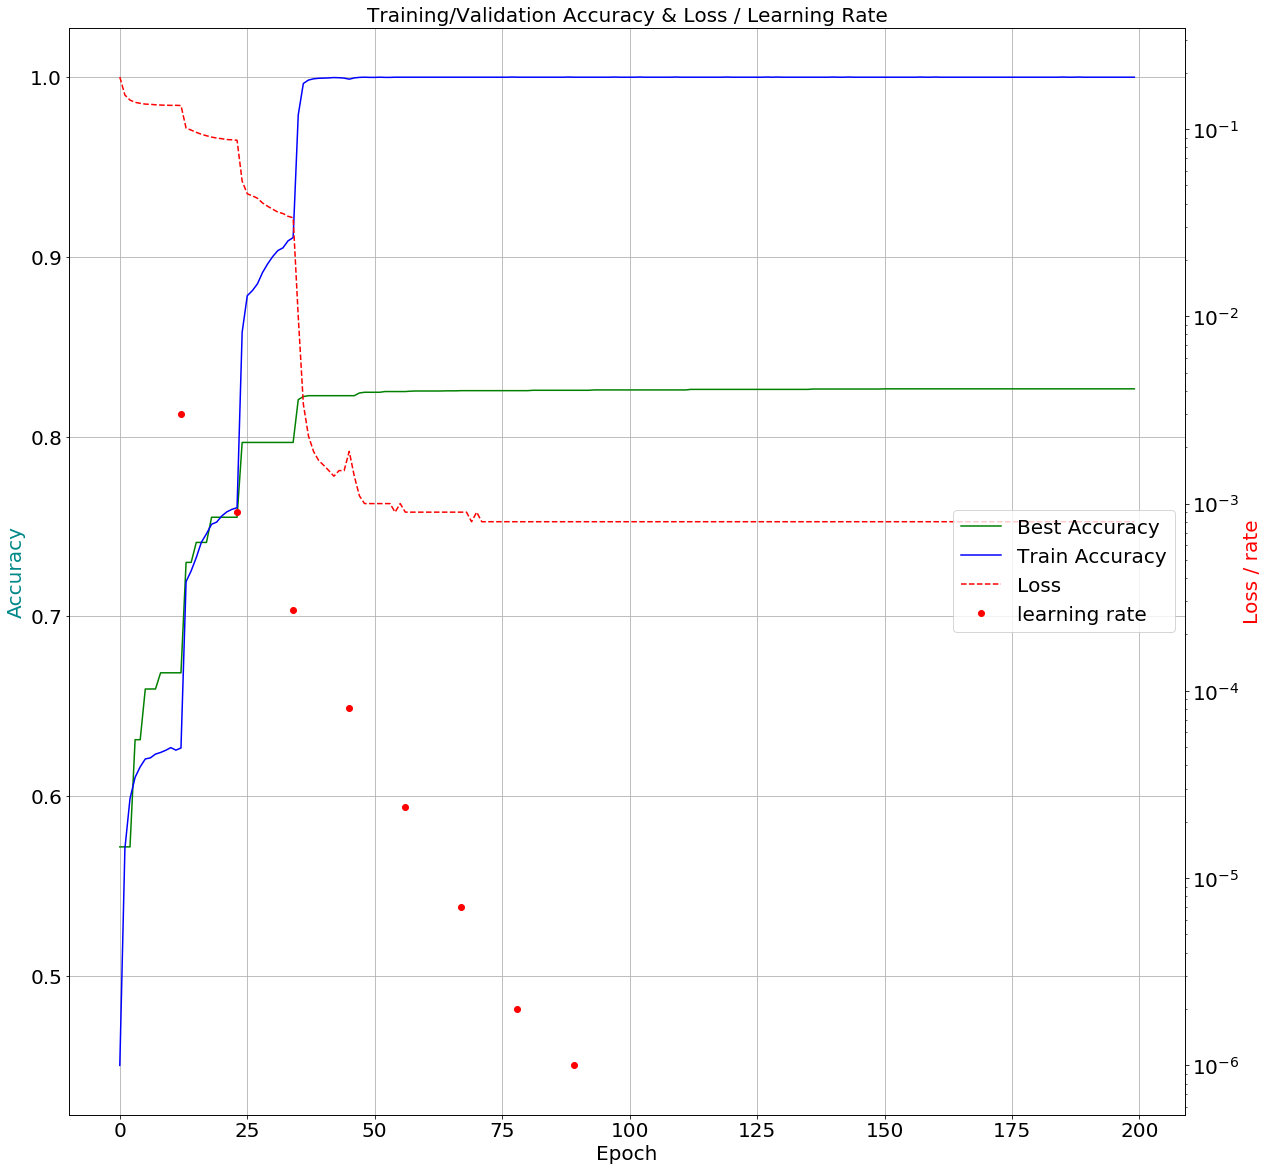

In [120]:
show_train_acc(dictionary_best, dictionary_acc, dictionary_loss, dictionary_lr)